# Final model

### This notebook contains the code to load the existing models and test them
The final model consists of generating predictions according to the scores of two models which are:
1. **The spiral model:** Generates scores for spirals the user draws.
2. **The wave model:** Generates scores for the waves the user draws.

Both models will generate scores for the input images, then these scores will be added to together into a *joint score* and finally the prediction will be generated according the this *joint score*.

# This file contains the following:

### 1. Loading the models.
### 2. Testing the models with the raw data.
This test simulates how the data is pre-processed and fed to the model.
### 3 Testing the spiral and wave models individually.
This helps detect any problem with the models separately.
### 4. Testing how both models will be used together.
This tests how both the spiral and wave models contribute to the final prediction.
### 5. Testing the model with data drawn on Paint.
This simulates using data from slightly different distribution from the training dataset.
### 6. Conclusion and problems.
Discussing the performance of the models and addressing some potential problems.
### 7. Solutions.
Suggesting solutions to the potential problems.

In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
# Dataset imports:
from data.dataset import *

# Model imports:
import model_wave
import model_spiral

# PyTorch imports
import torch
import torchvision.transforms as T
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder

# NumPy imports:
import numpy as np

# OpenCV imports:
import cv2

# Matplotlib imports:
import matplotlib.pyplot as plt

# Utils imports
from utils.utils import plot_images, transform_image, TRANSFORMS, TRANSFORMS_PARAMS

# Other imports:
import os
import glob
import json
import random
from evaluate import evaluate
from data.data_generator import *
import math
from tqdm import tqdm

In [3]:
# This allows the matplotlib library to plot without any errors:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [5]:
dataset = ParkinsonDataset(type='spiral')

# 1. Loading the models

In [6]:
models = {'spiral' : 'model_spiral_v3', 'wave' : 'model_wave_v2'}

In [7]:
# Defining the paths of each model:
MODEL_PATH = os.path.dirname(os.path.abspath('__file__'))

SPIRAL_MODEL_PATH = os.path.join(MODEL_PATH, models['spiral'])
WAVE_MODEL_PATH = os.path.join(MODEL_PATH, models['wave'])

In [9]:
image_dim = (128, 128)

# Creating the models:
spiral_model = model_spiral.Model(image_dim=image_dim)
wave_model = model_wave.Model(image_dim=image_dim)

In [10]:
# Loading the models:
spiral_model.load_state_dict(torch.load(SPIRAL_MODEL_PATH))
wave_model.load_state_dict(torch.load(WAVE_MODEL_PATH))

# Setting the models to the evaluation mode:
spiral_model.eval()
wave_model.eval();

# 2. Testing the models with the raw data:

### Data preprocessing:

In [11]:
transform = T.Compose([
                        T.ToTensor(),
                        T.Grayscale(num_output_channels=1),
                        T.Resize(image_dim)
                        ])

### Creating the dataset:

In [12]:
# This dataset is only created in order to access the mapping of the features:
dataset = ParkinsonDataset(type='wave')
wave_spiral_mapping = dataset.rev_mapping

### Loading the datasets json:

In [17]:
# Getting the path of the json file:
DATASET_JSON_PATH = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'data', 'data_path.txt')

# Loading the json file:
with open(DATASET_JSON_PATH, 'r') as file:
    dataset_path_dict = json.loads(file.read())

# a. Test with the spiral data:

In [18]:
# Getting the raw dataset path:
DATASET_PATH = dataset_path_dict['raw_spiral']

# Creating the dataset
spiral_dataset = ImageFolder(DATASET_PATH)

In [19]:
healthy_indecies = np.arange(51)
parkinson_indecies = np.arange(51, 102)

## The cell below simulates how the images of spirals should be created when fed to the model:
### Four images will be inputed and then layered on top of each other into a new image and, finally, will
### be fed to the model:

In [28]:
SAMPLE_SIZE = 4
# Getting 4 random healthy spiral images:
random_healthy_sample = np.random.choice(healthy_indecies, SAMPLE_SIZE)

# Defining an image of zeroes to accumulate the images on:
final_image = np.zeros((256, 256, 3))

# Simulating entering 4 different images and stacking them on top of each other
# and then feeding them to the model to get predictions:
for index in random_healthy_sample:
    
    image = spiral_dataset[index][0]
    # Tranforming the image to follow the distribution of the training dataset:
    image = transform_image(image, TRANSFORMS, TRANSFORMS_PARAMS)
    
    # Transforming the image to fit the model parameters:
    test_im = transform(image)
    
    # Accumulating the images:
    final_image += image

# --- Normalizing the image -----------
final_image = transform(final_image)
# Setting any pixel values that is greater than 255 to 255:
final_image[final_image > 255] = 255
# Dividing the images by maximum value a pixel can take so that the pixels will
# range between [0, 1]
final_image = final_image / 255
# -------------------------------------
# Plot the image:
im_to_show = np.transpose(final_image.cpu().detach().numpy(), (1, 2, 0))
plt.title('Healthy')
plt.imshow(im_to_show.squeeze())

### Predicting the class label (Healthy/Parkinson):

In [24]:
pred = spiral_model(final_image.view(1, *final_image.shape).float())

In [25]:
_, y_pred = torch.max(pred, axis=1)
print(f'Predicted class: {wave_spiral_mapping[y_pred.item()]}')

Predicted class: healthy


# b. Test the wave data:

In [29]:
DATASET_PATH = dataset_path_dict['raw_wave']

wave_dataset = ImageFolder(DATASET_PATH)

In [30]:
healthy_indecies = np.arange(51)
parkinson_indecies = np.arange(51, 102)

## The cell below simulates how the images of waves should be created when fed to the model:
### Four images will be inputed and then layered on top of each other into a new image and, finally, will
### be fed to the model:

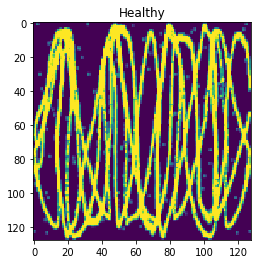

In [32]:
SAMPLE_SIZE = 4
# Getting 4 random healthy spiral images:
random_healthy_sample = np.random.choice(healthy_indecies, SAMPLE_SIZE)

# Defining an image of zeroes to accumulate the images on:
final_image = np.zeros((256, 256, 3))

# Simulating entering 4 different images and stacking them on top of each other
# and then feeding them to the model to get predictions:
for index in random_healthy_sample:
    image = wave_dataset[index][0]
    
    image = transform_image(image, TRANSFORMS, TRANSFORMS_PARAMS)
    # Transforming the image to fit the model parameters:
    test_im = transform(image)
    
    # Accumulating the images:
    final_image += image

# --- Normalizing the image -----------
final_image = transform(final_image)
# Setting any pixel values that is greater than 255 to 255:
final_image[final_image > 255] = 255
# Dividing the images by maximum value a pixel can take so that the pixels will
# range between [0, 1]
final_image = final_image / 255
# -------------------------------------
# Plot the image:
im_to_show = np.transpose(final_image.cpu().detach().numpy(), (1, 2, 0))
plt.title('Healthy')
plt.imshow(im_to_show.squeeze())

### Predicting the class label (Healthy/Parkinson):

In [33]:
pred = wave_model(final_image.view(1, *final_image.shape).float())

In [34]:
_, y_pred = torch.max(pred, axis=1)
print(f'Predicted class: {wave_spiral_mapping[y_pred.item()]}')

Predicted class: healthy


# 3. Testing the spiral and wave models individually.

## a. Testing the spiral model with a subset of the original spiral data:

### Creating the dataset object:

In [89]:
spiral_dataset = ParkinsonDataset(type='spiral')

### Creating a subset of the original spiral dataset:

In [90]:
subset_size = 2000
# The indecies of the sampled data:
spiral_indecies = np.random.choice(np.arange(len(spiral_dataset)), subset_size)

# Creating the subset:
spiral_subset = Subset(spiral_dataset, spiral_indecies)

### Creating the DataLoader:

In [91]:
batch_size, num_workers = 16, 6

spiral_data_loader = DataLoader(dataset=spiral_subset, batch_size=batch_size, num_workers=num_workers, pin_memory=True)

### Starting the evaluation:

In [92]:
accuracy = evaluate(model=spiral_model, data_loader=spiral_data_loader)

In [94]:
print(f'The accuracy of the spiral_model on a subset of the original dataset of size {subset_size} is: {accuracy:.2f}%')

The accuracy of the spiral_model on a subset of the original dataset of size 2000 is: 98.70%


## b. Testing the wave model with a subset of the original wave data:

### Creating the dataset object:

In [95]:
wave_dataset = ParkinsonDataset(type='wave')

### Creating a subset of the original wave dataset:

In [96]:
subset_size = 2000
# The indecies of the sampled data:
wave_indecies = np.random.choice(np.arange(len(wave_dataset)), subset_size)

# Creating the subset:
wave_subset = Subset(wave_dataset, wave_indecies)

### Creating the DataLoader:

In [97]:
batch_size, num_workers = 16, 6

wave_data_loader = DataLoader(dataset=wave_subset, batch_size=batch_size, num_workers=num_workers, pin_memory=True)

### Starting the evaluation:

In [98]:
accuracy = evaluate(model=wave_model, data_loader=wave_data_loader)

In [99]:
print(f'The accuracy of the wave_model on a subset of the original dataset of size {subset_size} is: {accuracy:.2f}%')

The accuracy of the wave_model on a subset of the original dataset of size 2000 is: 99.00%


# 4. Testing how both models will be used together:

### Pre-processing:

In [35]:
new_image_dim = (128, 128)

transform = T.Compose([
    T.ToTensor(),
    T.Grayscale(num_output_channels=1),
    T.Resize(new_image_dim)
])

### Defining the datasets:

In [36]:
spiral_dataset = ParkinsonDataset(type='spiral', transform=transform)
wave_dataset = ParkinsonDataset(type='wave', transform=transform)

### Creating subsets for both spiral and wave data from the original dataset:

In [38]:
sample_size = 1500
# Creating the indecies of the subset. Those indecies consist of a random sample from the dataset.
indecies = np.random.choice(np.arange(len(spiral_dataset)), sample_size)

In [39]:
spiral_subset = Subset(spiral_dataset, indecies)
wave_subset = Subset(wave_dataset, indecies)

### Creating the data loaders with the sampler:

In [40]:
batch_size = 1
spiral_dataloader = DataLoader(dataset=spiral_subset, pin_memory=True, batch_size=batch_size)
wave_dataloader = DataLoader(dataset=wave_subset, pin_memory=True, batch_size=batch_size)

## In the code snippet below, both the spiral and the wave models will contribute to the last prediction. This happens as follows: 
1. Scores from the spiral model are generated, 
2. Scores from the wave model are generated, 
3. Both the spiral and wave scores are added together,
4. Finally, argmax is applied on the joint score and the predicted class is selected.

In [41]:
preds = []
truth = []

for X_spiral, X_wave in tqdm(zip(spiral_dataloader, wave_dataloader)):
    x_spiral, y_spiral = X_spiral
    x_wave, y_wave = X_wave
    
    # Moving the images and labels to the selected device:
    x_spiral, y_spiral = x_spiral.to(device), y_spiral.to(device)
    x_wave, y_wave = x_wave.to(device), y_wave.to(device)
    
    # Moving the models to the selected device:
    spiral_model = spiral_model.to(device)
    wave_model = wave_model.to(device)
    
    # Creating a place holder that will hold the joint score:
    score = torch.zeros_like(y_spiral)
    
    # Generating the scores from the models:
    pred_spiral = spiral_model(x_spiral)
    pred_wave = wave_model(x_wave)
    
    # Adding both the spiral and wave scores:
    score = pred_spiral + pred_wave
    
    # Applying argmax on the joint scores:
    _, final_pred = torch.max(score, axis=1)
    
    # Appending the prediction to a list so it can be compared to the ground truth:
    preds.append(spiral_dataset.rev_mapping[final_pred.item()])   
    
    # y_spiral and y_wave have the same value so y_spiral was arbitrarly selected to be added
    # as the ground truth:
    truth.append(spiral_dataset.rev_mapping[y_spiral.item()])
    

1500it [00:22, 67.10it/s]


In [42]:
# Converting the predictions and ground truth lists to numpy arrays:
preds = np.array(preds)
truth = np.array(truth)

### Evaluating the model with the subsets created above:

In [43]:
# Calculating the accuracy of the model:
accuracy = np.sum(preds==truth) / len(preds)

In [44]:
print(f'Accuracy: {100 * accuracy:.2f}%')

Accuracy: 100.00%


# 5. Testing the model with data drawn on Paint:

### Getting the data path:

In [45]:
SPIRAL_DATA_PATH = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'random_data', 'spiral')
WAVE_DATA_PATH = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'random_data', 'wave')

### Loading the image paths:

In [46]:
spiral_images_paths = glob.glob(os.path.join(SPIRAL_DATA_PATH, '*.png'))
wave_images_paths = glob.glob(os.path.join(WAVE_DATA_PATH, '*.png'))

### Loading the labels:

In [47]:
spiral_labels = [l.split('_')[0] for l in os.listdir(SPIRAL_DATA_PATH)]
wave_labels = [l.split('_')[0] for l in os.listdir(WAVE_DATA_PATH)]

### Loading the images:

In [48]:
spiral_images = []
wave_images = []

for spiral_path, wave_path in zip(spiral_images_paths, wave_images_paths):
    
    # --- Loading and transforming a spiral image: ---------------------
    # Loading a spiral image:
    spiral_image = cv2.imread(spiral_path)
    
    # Transforming the spiral images so it fits the distrubution of the
    # training data:
    spiral_image = transform_image(image=spiral_image,
                                   transforms=TRANSFORMS,
                                   transforms_params=TRANSFORMS_PARAMS)
    
    spiral_images.append(spiral_image)
    
    # --- Loading and transforming a wave image: ----------------------
    # Loading a wave image:
    wave_image = cv2.imread(wave_path)
    
    # Transforming the wave images so it fits the distrubution of the
    # training data:
    wave_image = transform_image(image=wave_image,
                                transforms=TRANSFORMS,
                                transforms_params=TRANSFORMS_PARAMS)
    
    wave_images.append(wave_image)

# Visualizing the spiral images with thier labels and predictions:

### Generating predictions for the spiral images drawn using paint:

In [65]:
preds = []

for image in spiral_images:
    # Moving the model to the selected device:
    spiral_model = spiral_model.to(device)
    
    # Transforming the image so it fits the model:
    image = DEFAULT_TRANSFORM(image)
    image = image.view(1, *image.shape)
    
    # Moving the image to the selected device:
    image = image.to(device)
    
    # Generating the prediction:
    y_pred = spiral_model(image)
    
    # Applying argmax:
    _, y_pred = torch.max(y_pred, axis=1)
    
    # Coverting the predicted label to text:
    y_pred = wave_spiral_mapping[y_pred.item()]
    
    # Appeding the prediction to the preds array:
    preds.append(y_pred)

In [66]:
spiral_labels_preds = [f'True: {true} | Pred: {pred}' for true, pred in zip(spiral_labels, preds)]

In [67]:
plot_images(images=spiral_images, labels=spiral_labels_preds, subplots=(3, 3), transform=DEFAULT_TRANSFORM)

In [74]:
spiral_accuracy = np.sum(np.array(preds)==np.array(spiral_labels)) / len(spiral_labels)
print(f'Accuracy of the {len(spiral_labels)} spiral images drawn on Paint: {100 * spiral_accuracy:.2f}%')

Accuracy of the 9 images drawn on Paint: 88.89%


# Visualizing the wave images with thier labels and predictions:

### Generating predictions for the spiral images drawn using paint:

In [ ]:
preds = []

for image in wave_images:
    # Moving the model to the selected device:
    wave_model = wave_model.to(device)
    
    # Transforming the image so it fits the model:
    image = DEFAULT_TRANSFORMS(image)
    image = image.view(1, *image.shape)
    
    # Moving the image to the selected device:
    image = image.to(device)
    
    # Generating the prediction:
    y_pred = model(image)
    
    # Applying argmax:
    _, y_pred = torch.max(y_pred, axis=1)
    
    # Coverting the predicted label to text:
    y_pred = wave_spiral_mapping(y_pred.item())
    
    # Appeding the prediction to the preds array:
    preds.append(y_pred)

In [68]:
wave_labels_preds = [f'True: {true} | Pred: {pred}' for true, pred in zip(wave_labels, preds)]

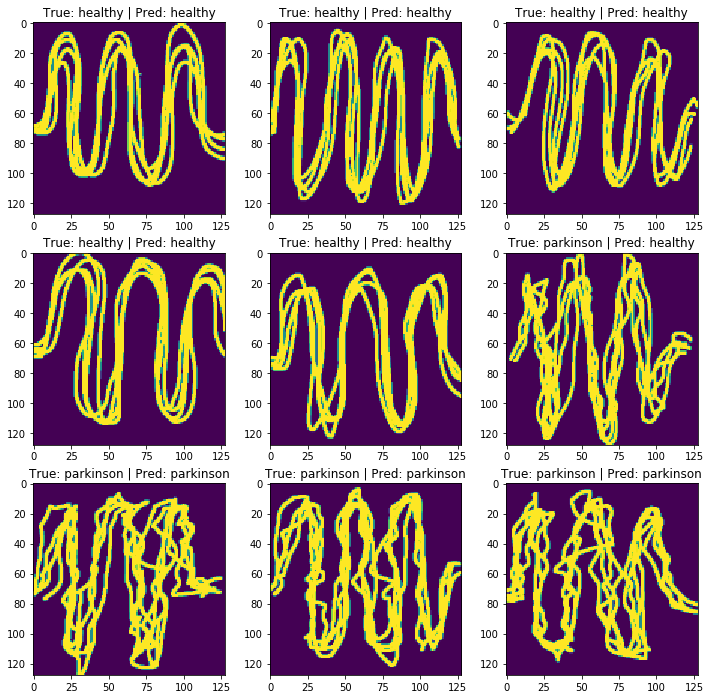

In [70]:
plot_images(images=wave_images, labels=wave_labels_preds, subplots=(3, 3), transform=DEFAULT_TRANSFORM)

In [75]:
wave_accuracy = np.sum(np.array(preds)==np.array(wave_labels)) / len(wave_labels)
print(f'Accuracy of the {len(wave_labels)} wave images drawn on Paint: {100 * wave_accuracy:.2f}%')

Accuracy of the 9 wave images drawn on Paint: 88.89%


# Generating predictions from both models for the images drawn using Paint:

In [56]:
preds = []

for spiral_image, wave_image in tqdm(zip(spiral_images, wave_images)):
    
    # Moving the models to the selected device:
    spiral_model = spiral_model.to(device)
    wave_model = wave_model.to(device) 
    
    # --- Generating the score for the spiral image: -----------
    # Transforming then moving the image to the selected device:
    spiral_image = DEFAULT_TRANSFORM(spiral_image).to(device)
    
    # Generating the scores:
    spiral_scores = spiral_model(spiral_image.view(1, *spiral_image.shape))
    
    # --- Generating the score for the wave image: -------------
    # Transforming then moving the image to the selected device:
    wave_image = DEFAULT_TRANSFORM(wave_image).to(device)
    
    # Generating the scores:
    wave_scores = wave_model(wave_image.view(1, *wave_image.shape))
    
    # ----------------------------------------------------------
    # Adding the spiral and wave scores:
    joint_scores = spiral_scores + wave_scores
    
    # Applying argmax to the scores to get the predicted class:
    _, pred = torch.max(joint_scores, axis=1)
    pred = wave_spiral_mapping[pred.item()]
    
    preds.append(pred) 

9it [00:00, 53.90it/s]


# Evaluating the model:

In [58]:
# Since the spiral and wave labels are the same spiral_labels was chosen arbitrarily to
# be the ground truth:
ground_truth = np.array(spiral_labels)
preds = np.array(preds)

In [59]:
accuracy = np.sum(ground_truth==preds) / len(preds)

In [60]:
print(f'Accuracy: {100 * accuracy:.2f}%')

Accuracy: 88.89%


# 6. Conclusion and problems:

### The model preformed pretty well on a subset of the original dataset, however, it performed relatively poor (compared to its perfomance on the original data) with the data drawn on Paint. This could be due to several reasons:
### 1) The data drawn on Paint is very small compared to the original data.
### 2) The data drawn on Paint was drawn by someone who does not have Parkinson which means that the Parkinson images may not represent what a real patient would draw. As a support to this, there was no Healthy drawing that was identified as Parkinson.

## *NOTE*: 
### This is not a huge problem since we can define some guidelines for the end-user when they are drawing spirals and waves such that the images drawn by the user conform with the distribution of the training data.

# 7. Solutions:

### 1. The model should be tested with data that has the same or slightly different distribution to the original dataset.
### 2. Define guidelines to the user when drawing spirals and waves such that the drawings conform with the training data distribution.